## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')
import cv2

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU available: {len(tf.config.list_physical_devices("GPU")) > 0}')

2026-01-12 06:40:40.953630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768200041.157012      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768200041.212853      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768200041.691371      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768200041.691434      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768200041.691438      55 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU available: True


## 2. Data Preprocessing

### 2.1 Load Data

In [2]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

def create_dataframe(data_dir):
    filepaths, labels = [], []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                filepaths.append(os.path.join(class_path, img_name))
                labels.append(class_name)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

print(f'Training samples: {len(train_df)}')
print(f'Testing samples: {len(test_df)}')
print(f'\nClasses: {train_df["label"].unique()}')

Training samples: 5712
Testing samples: 1311

Classes: ['pituitary' 'notumor' 'meningioma' 'glioma']


### 2.2 Chia Train/Valid/Test

In [3]:
valid_df, test_df = train_test_split(
    test_df, train_size=0.5, random_state=42, stratify=test_df['label']
)

print(f'Train: {len(train_df)}')
print(f'Valid: {len(valid_df)}')
print(f'Test: {len(test_df)}')

Train: 5712
Valid: 655
Test: 656


### 2.3 Data Visualization

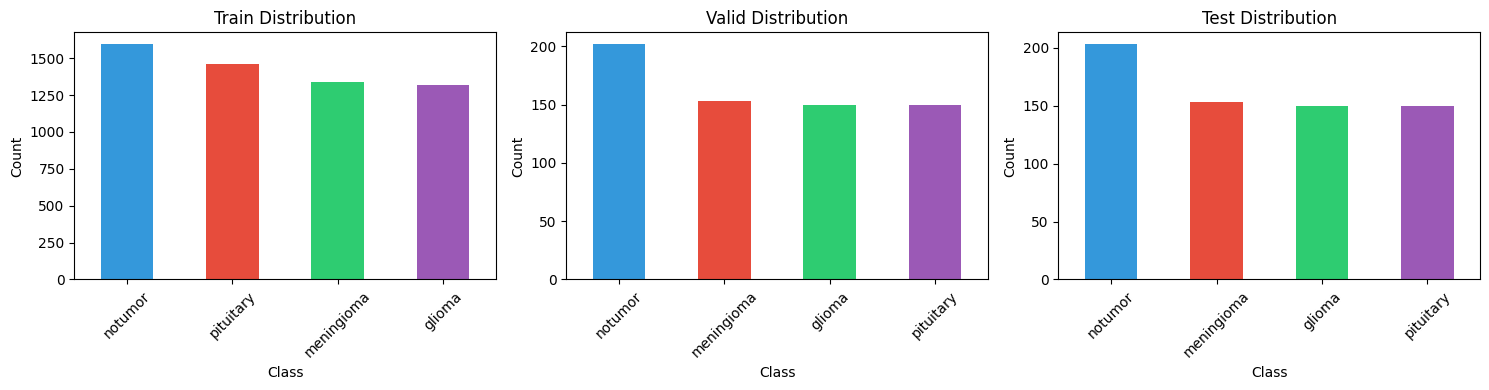

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, df) in zip(axes, [('Train', train_df), ('Valid', valid_df), ('Test', test_df)]):
    df['label'].value_counts().plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'])
    ax.set_title(f'{name} Distribution')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## 3. Tiền xử lý dữ liệu

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def resize_with_padding(image, target_size=(224, 224)):
    """Resize ảnh mà KHÔNG bị méo (thêm viền đen)"""
    h, w = image.shape[:2]
    target_h, target_w = target_size
    
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    resized = cv2.resize(image, (new_w, new_h))
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return canvas

def preprocess_image(image):
    """Pure ResNet50 ImageNet preprocessing"""
    # Convert to float32
    image = image.astype(np.float32)
    
    # Convert RGB to BGR
    image = image[..., ::-1]
    
    # Zero-center by ImageNet mean (BGR order)
    image[..., 0] -= 103.939  # Blue
    image[..., 1] -= 116.779  # Green  
    image[..., 2] -= 123.68   # Red
    
    return image

In [6]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, img_size=(224, 224), 
                 augment=False, shuffle=True, class_names=None):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.class_names = class_names or sorted(dataframe['label'].unique())
        self.n_classes = len(self.class_names)
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.df.iloc[batch_indexes]
        X = np.zeros((len(batch_data), *self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_data), self.n_classes), dtype=np.float32)
        
        for i, (_, row) in enumerate(batch_data.iterrows()):
            img = cv2.imread(row['filepath'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = resize_with_padding(img, self.img_size)
            
            if self.augment:
                img = self._augment(img)
            
            X[i] = preprocess_image(img)
            
            label_idx = self.class_names.index(row['label'])
            y[i, label_idx] = 1.0
        
        return X, y
    
    def _augment(self, img):
        if np.random.random() > 0.5:
            img = cv2.flip(img, 1)
        
        angle = np.random.uniform(-15, 15)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        img = cv2.warpAffine(img, M, (w, h), borderValue=0)
        
        factor = np.random.uniform(0.9, 1.1)
        img = np.clip(img * factor, 0, 255).astype(np.uint8)
        
        return img
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [7]:
class_names = sorted(train_df['label'].unique())

train_generator = CustomDataGenerator(
    train_df, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augment=True, 
    shuffle=True, 
    class_names=class_names
)

valid_generator = CustomDataGenerator(
    valid_df, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augment=False, 
    shuffle=False, 
    class_names=class_names
)

test_generator = CustomDataGenerator(
    test_df, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augment=False, 
    shuffle=False, 
    class_names=class_names
)

## 4. ResNet50 Model

In [8]:

def build_resnet50_model(input_shape=(224, 224, 3), num_classes=4):
    """Build ResNet50 with fine-tuning"""
    # Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze all base layers initially
    for layer in base_model.layers:
        layer.trainable = False
    
    # Build complete model
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='ResNet50_BrainTumor')
    
    return model, base_model

# Build model
IMG_SHAPE = (224, 224, 3)
NUM_CLASSES = len(class_names)

model, base_model = build_resnet50_model(IMG_SHAPE, NUM_CLASSES)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())
print(f'\nTotal params: {model.count_params():,}')

I0000 00:00:1768200055.456904      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "ResNet50_BrainTumor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,779,396 (94.53 MB)

 Trainable params: 1,186,564 (4.53 MB)

 Non-trainable params: 23,592,832 (90.00 MB)

None

Total params: 24,779,396


Kiến trúc mô hình ResNet50 dựa trên phương pháp học chuyển giao (Transfer Learning).

Sử dụng ResNet50 pretrained trên ImageNet làm backbone trích xuất đặc trưng

Loại bỏ tầng phân loại gốc của ImageNet

Thêm các tầng phân loại mới phù hợp với bài toán phân loại u não

Mục tiêu là tạo ra một mô hình có khả năng tận dụng tri thức đã học từ dữ liệu lớn và thích nghi với dữ liệu MRI.

## 5. Training

In [9]:
# Stage 1: Train only top layers
print("STAGE 1: Training top layers (base frozen)")

callbacks_stage1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_resnet50_stage1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

EPOCHS_STAGE1 = 20
history_stage1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks_stage1
)

STAGE 1: Training top layers (base frozen)
Epoch 1/20


I0000 00:00:1768200073.616264     128 service.cc:152] XLA service 0x7a8850014f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768200073.616310     128 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768200075.735109     128 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/179 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.3438 - loss: 1.9015  

I0000 00:00:1768200081.442909     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7486 - loss: 0.6967
Epoch 1: val_accuracy improved from -inf to 0.89008, saving model to best_resnet50_stage1.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 118s 573ms/step - accuracy: 0.7490 - loss: 0.6957 - val_accuracy: 0.8901 - val_loss: 0.2923 - learning_rate: 0.0010
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8791 - loss: 0.3272
Epoch 2: val_accuracy improved from 0.89008 to 0.91603, saving model to best_resnet50_stage1.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step - accuracy: 0.8792 - loss: 0.3272 - val_accuracy: 0.9160 - val_loss: 0.2444 - learning_rate: 0.0010
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9005 - loss: 0.2691
Epoch 3: val_accuracy improved from 0.91603 to 0.92214, saving model to best_resnet50_stage1.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step - accuracy: 0.9005 - loss: 0.2691 - val_accuracy: 0.9221 - val_loss: 0.2186 - learning_rate: 0.0010
Epoch 4/20
179/179 ━

Thực hiện giai đoạn huấn luyện đầu tiên của mô hình ResNet50.

Trong giai đoạn này:

Toàn bộ backbone ResNet50 được đóng băng (không cập nhật trọng số)

Chỉ huấn luyện các tầng phân loại mới được thêm vào

Mục tiêu của giai đoạn này là giúp mô hình học cách ánh xạ đặc trưng trích xuất sang các lớp u não mà không làm thay đổi kiến thức gốc từ ImageNet.

In [10]:
# Stage 2: Fine-tune last 10 layers

print("STAGE 2: Fine-tuning last 10 layers")

# Unfreeze last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

print(f"Trainable layers: {sum([1 for l in base_model.layers if l.trainable])}/{len(base_model.layers)}")

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_stage2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=12,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_resnet50_finetuned.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

EPOCHS_STAGE2 = 50
history_stage2 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks_stage2
)

STAGE 2: Fine-tuning last 10 layers
Trainable layers: 10/175
Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9494 - loss: 0.1304
Epoch 1: val_accuracy improved from -inf to 0.95267, saving model to best_resnet50_finetuned.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 287ms/step - accuracy: 0.9494 - loss: 0.1304 - val_accuracy: 0.9527 - val_loss: 0.1291 - learning_rate: 1.0000e-04
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9644 - loss: 0.0972
Epoch 2: val_accuracy improved from 0.95267 to 0.96336, saving model to best_resnet50_finetuned.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 212ms/step - accuracy: 0.9644 - loss: 0.0973 - val_accuracy: 0.9634 - val_loss: 0.0965 - learning_rate: 1.0000e-04
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9735 - loss: 0.0729
Epoch 3: val_accuracy improved from 0.96336 to 0.97252, saving model to best_resnet50_finetuned.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.9735 - loss: 0.072

Thực hiện giai đoạn fine-tuning mô hình ResNet50.

Mở khóa một số lớp cuối của backbone ResNet50

Huấn luyện lại mô hình với learning rate nhỏ hơn

Mục tiêu của fine-tuning là điều chỉnh đặc trưng cấp cao của mô hình sao cho phù hợp hơn với dữ liệu MRI, đồng thời tránh làm mất các đặc trưng tổng quát đã học trước đó.

### Visualize Training History

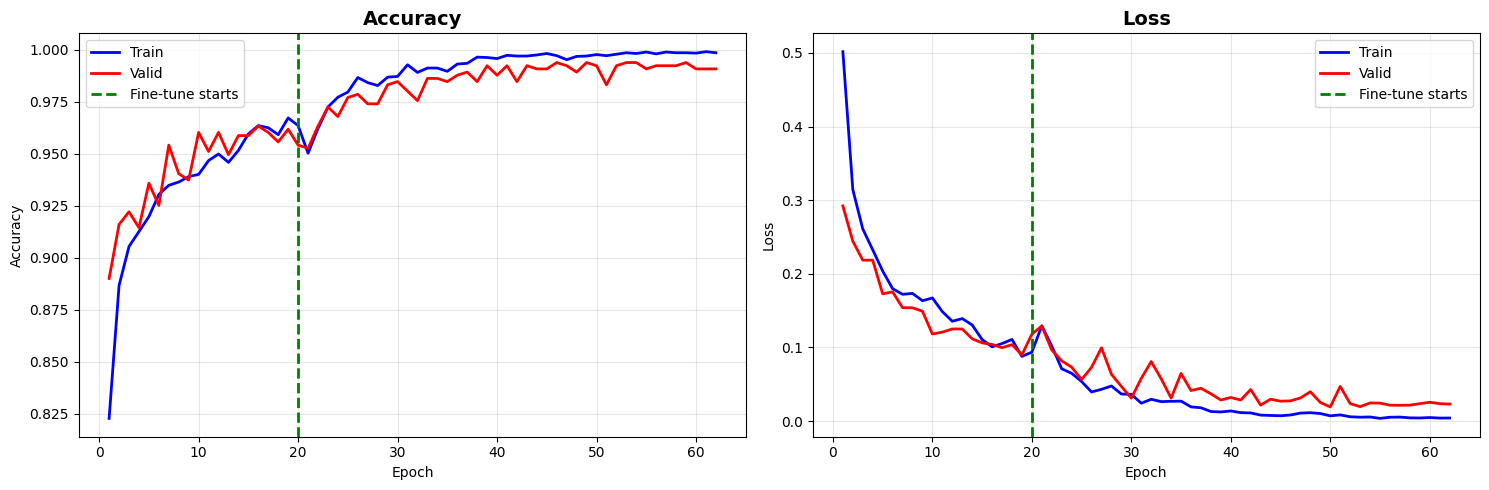


Best Train Accuracy: 99.91%
Best Valid Accuracy: 99.39%


In [11]:
def plot_history(history1, history2):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    stage1_epochs = len(history1.history['accuracy'])
    epochs = range(1, len(acc) + 1)
    
    axes[0].plot(epochs, acc, 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs, val_acc, 'r-', label='Valid', linewidth=2)
    axes[0].axvline(x=stage1_epochs, color='green', linestyle='--', label='Fine-tune starts', linewidth=2)
    axes[0].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs, loss, 'b-', label='Train', linewidth=2)
    axes[1].plot(epochs, val_loss, 'r-', label='Valid', linewidth=2)
    axes[1].axvline(x=stage1_epochs, color='green', linestyle='--', label='Fine-tune starts', linewidth=2)
    axes[1].set_title('Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f'\nBest Train Accuracy: {max(acc)*100:.2f}%')
    print(f'Best Valid Accuracy: {max(val_acc)*100:.2f}%')

plot_history(history_stage1, history_stage2)

## 5.5 K-Fold Cross Validation

K-FOLD CROSS VALIDATION (k=5)

Total samples for k-fold: 6367
Class distribution:
label
notumor       1797
pituitary     1607
meningioma    1492
glioma        1471
Name: count, dtype: int64


FOLD 1/5
Train size: 5093
Valid size: 1274

Building model for fold 1...

[FOLD 1] STAGE 1: Training top layers (base frozen)
Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 64s 324ms/step - accuracy: 0.7546 - loss: 0.7148 - val_accuracy: 0.8870 - val_loss: 0.2875 - learning_rate: 0.0010
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step - accuracy: 0.8697 - loss: 0.3466 - val_accuracy: 0.9192 - val_loss: 0.2408 - learning_rate: 0.0010
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 245ms/step - accuracy: 0.8989 - loss: 0.2680 - val_accuracy: 0.9239 - val_loss: 0.2142 - learning_rate: 0.0010
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 239ms/step - accuracy: 0.9002 - loss: 0.2639 - val_accuracy: 0.9199 - val_loss: 0.2025 - learning_rate: 0.0010
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 248ms/step - accur

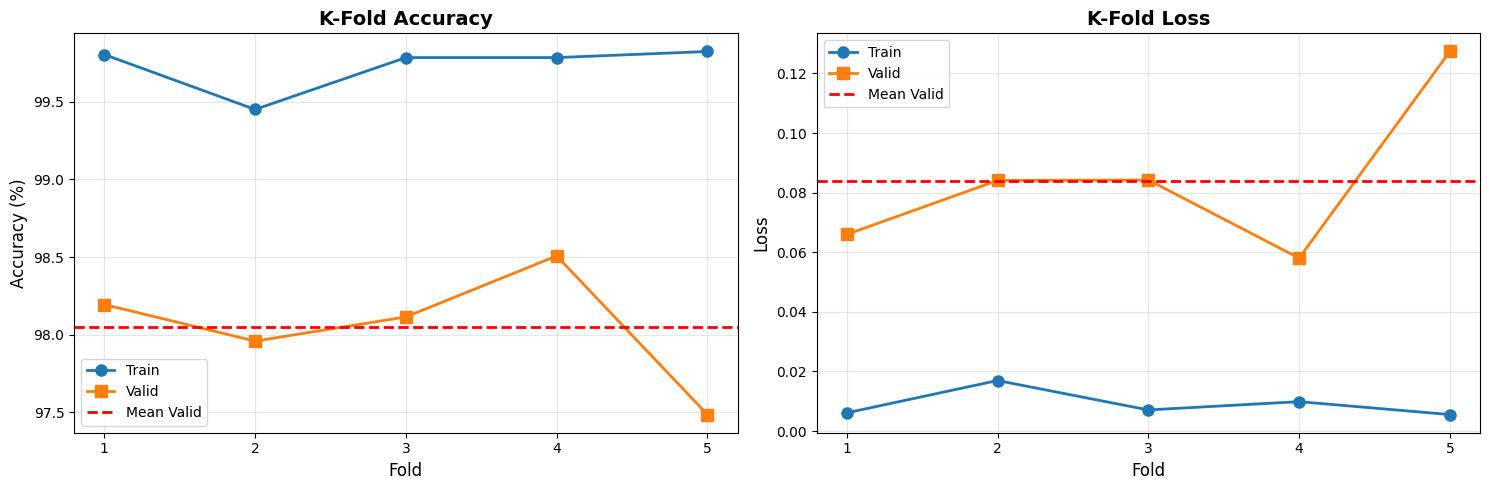


✓ K-Fold results saved to 'kfold_results.json'
✓ Best fold: Fold 4 with 98.51% validation accuracy


In [12]:
## K-Fold Cross Validation (k=5)

from sklearn.model_selection import StratifiedKFold
import json

print("=" * 80)
print("K-FOLD CROSS VALIDATION (k=5)")
print("=" * 80)

# Combine train + valid data for cross validation
full_train_df = pd.concat([train_df, valid_df], ignore_index=True)
print(f"\nTotal samples for k-fold: {len(full_train_df)}")
print(f"Class distribution:\n{full_train_df['label'].value_counts()}\n")

# Initialize k-fold
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store results
fold_results = {
    'fold': [],
    'train_acc': [],
    'val_acc': [],
    'train_loss': [],
    'val_loss': []
}

# K-Fold loop
for fold, (train_idx, val_idx) in enumerate(skf.split(full_train_df, full_train_df['label']), 1):
    print("\n" + "=" * 80)
    print(f"FOLD {fold}/{k_folds}")
    print("=" * 80)
    
    # Split data
    fold_train_df = full_train_df.iloc[train_idx].reset_index(drop=True)
    fold_val_df = full_train_df.iloc[val_idx].reset_index(drop=True)
    
    print(f"Train size: {len(fold_train_df)}")
    print(f"Valid size: {len(fold_val_df)}")
    
    # Create generators
    fold_train_gen = CustomDataGenerator(
        fold_train_df,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        augment=True,
        shuffle=True,
        class_names=class_names
    )
    
    fold_val_gen = CustomDataGenerator(
        fold_val_df,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        augment=False,
        shuffle=False,
        class_names=class_names
    )
    
    # Build fresh model for each fold
    print(f"\nBuilding model for fold {fold}...")
    fold_model, fold_base = build_resnet50_model(IMG_SHAPE, NUM_CLASSES)
    
    # Compile
    fold_model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    #  STAGE 1: Train top layers 
    print(f"\n[FOLD {fold}] STAGE 1: Training top layers (base frozen)")
    
    callbacks_s1 = [
        EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            f'fold{fold}_stage1.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    history_s1 = fold_model.fit(
        fold_train_gen,
        validation_data=fold_val_gen,
        epochs=20,
        callbacks=callbacks_s1,
        verbose=1
    )
    
    #  STAGE 2: Fine-tune last 10 layers 
    print(f"\n[FOLD {fold}] STAGE 2: Fine-tuning last 10 layers")
    
    # Unfreeze last 10 layers
    for layer in fold_base.layers[-10:]:
        layer.trainable = True
    
    # Recompile with lower lr
    fold_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks_s2 = [
        EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            f'fold{fold}_stage2.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    history_s2 = fold_model.fit(
        fold_train_gen,
        validation_data=fold_val_gen,
        epochs=50,
        callbacks=callbacks_s2,
        verbose=1
    )
    
    # Get final metrics
    final_train_loss = history_s2.history['loss'][-1]
    final_train_acc = history_s2.history['accuracy'][-1]
    final_val_loss = history_s2.history['val_loss'][-1]
    final_val_acc = history_s2.history['val_accuracy'][-1]
    
    # Store results
    fold_results['fold'].append(fold)
    fold_results['train_acc'].append(final_train_acc)
    fold_results['val_acc'].append(final_val_acc)
    fold_results['train_loss'].append(final_train_loss)
    fold_results['val_loss'].append(final_val_loss)
    
    print(f"\n[FOLD {fold}] RESULTS:")
    print(f"  Train Acc: {final_train_acc*100:.2f}% | Train Loss: {final_train_loss:.4f}")
    print(f"  Valid Acc: {final_val_acc*100:.2f}% | Valid Loss: {final_val_loss:.4f}")
    
    # Clear memory
    del fold_model, fold_base, fold_train_gen, fold_val_gen
    tf.keras.backend.clear_session()

# SUMMARY 

print("K-FOLD CROSS VALIDATION SUMMARY")


results_df = pd.DataFrame(fold_results)
print(results_df.to_string(index=False))

print(f"\n{'Metric':<20} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
print("-" * 68)
print(f"{'Train Accuracy':<20} {np.mean(fold_results['train_acc'])*100:>10.2f}%  {np.std(fold_results['train_acc'])*100:>10.2f}%  {np.min(fold_results['train_acc'])*100:>10.2f}%  {np.max(fold_results['train_acc'])*100:>10.2f}%")
print(f"{'Valid Accuracy':<20} {np.mean(fold_results['val_acc'])*100:>10.2f}%  {np.std(fold_results['val_acc'])*100:>10.2f}%  {np.min(fold_results['val_acc'])*100:>10.2f}%  {np.max(fold_results['val_acc'])*100:>10.2f}%")
print(f"{'Train Loss':<20} {np.mean(fold_results['train_loss']):>11.4f}  {np.std(fold_results['train_loss']):>11.4f}  {np.min(fold_results['train_loss']):>11.4f}  {np.max(fold_results['train_loss']):>11.4f}")
print(f"{'Valid Loss':<20} {np.mean(fold_results['val_loss']):>11.4f}  {np.std(fold_results['val_loss']):>11.4f}  {np.min(fold_results['val_loss']):>11.4f}  {np.max(fold_results['val_loss']):>11.4f}")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(fold_results['fold'], np.array(fold_results['train_acc'])*100, 'o-', label='Train', linewidth=2, markersize=8)
axes[0].plot(fold_results['fold'], np.array(fold_results['val_acc'])*100, 's-', label='Valid', linewidth=2, markersize=8)
axes[0].axhline(y=np.mean(fold_results['val_acc'])*100, color='red', linestyle='--', label='Mean Valid', linewidth=2)
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('K-Fold Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(fold_results['fold'])

# Loss plot
axes[1].plot(fold_results['fold'], fold_results['train_loss'], 'o-', label='Train', linewidth=2, markersize=8)
axes[1].plot(fold_results['fold'], fold_results['val_loss'], 's-', label='Valid', linewidth=2, markersize=8)
axes[1].axhline(y=np.mean(fold_results['val_loss']), color='red', linestyle='--', label='Mean Valid', linewidth=2)
axes[1].set_xlabel('Fold', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('K-Fold Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(fold_results['fold'])

plt.tight_layout()
plt.show()

# Save results
with open('kfold_results.json', 'w') as f:
    json.dump(fold_results, f, indent=4)

print(f"\n K-Fold results saved to 'kfold_results.json'")
print(f" Best fold: Fold {fold_results['fold'][np.argmax(fold_results['val_acc'])]} with {np.max(fold_results['val_acc'])*100:.2f}% validation accuracy")

Triển khai phương pháp xác thực chéo K-Fold Cross Validation với k = 5 nhằm đánh giá độ ổn định của mô hình ResNet50.

Quy trình gồm:
- Chia tập dữ liệu thành 5 phần bằng nhau
- Mỗi lần sử dụng 4 phần để huấn luyện và 1 phần để kiểm định
- Lặp lại quá trình 5 lần để mỗi phần dữ liệu đều được dùng làm tập kiểm định

Kết quả của mỗi fold được lưu lại để tính toán giá trị trung bình và độ lệch chuẩn của các chỉ số đánh giá.


Kết quả huấn luyện và đánh giá từ tất cả các fold trong K-Fold Cross Validation.

Các chỉ số được thống kê bao gồm:
- Accuracy trung bình
- Độ lệch chuẩn (Std)
- Giá trị lớn nhất và nhỏ nhất

Các kết quả này phản ánh khả năng tổng quát hóa và độ ổn định của mô hình trên nhiều tập dữ liệu khác nhau.

## 6. Evaluation

21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9956 - loss: 0.0119

Test Accuracy: 99.70%
Test Loss: 0.0081
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 387ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       150
  meningioma       0.99      1.00      0.99       153
     notumor       1.00      1.00      1.00       203
   pituitary       1.00      1.00      1.00       150

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656



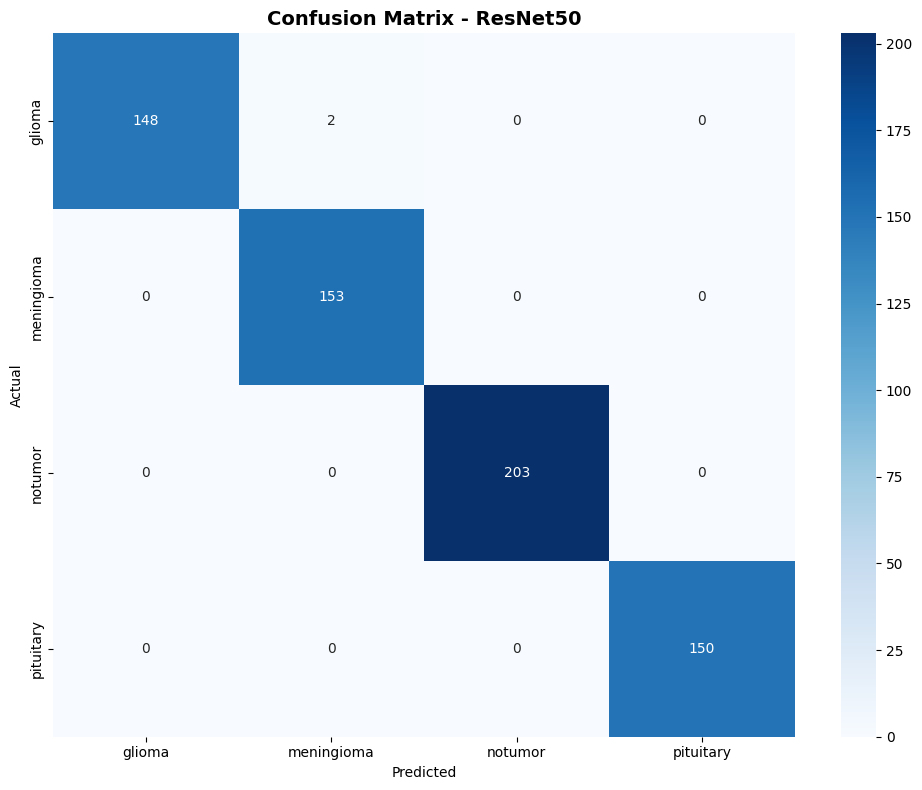

In [13]:
# Load best model
model = tf.keras.models.load_model('best_resnet50_finetuned.keras')

# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# Predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = [class_names.index(label) for label in test_df['label'].values]

# Classification Report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - ResNet50', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

Đánh giá hiệu năng của mô hình ResNet50 cuối cùng sau khi đã hoàn tất quá trình huấn luyện và fine-tuning.

Cụ thể:
- Tải mô hình ResNet50 tốt nhất đã được huấn luyện trên toàn bộ tập dữ liệu
- Đánh giá mô hình trên tập kiểm thử (test set) chưa từng xuất hiện trong quá trình huấn luyện
- Tính toán các chỉ số đánh giá như Accuracy và Loss
- Sinh dự đoán để xây dựng Classification Report và Confusion Matrix

Cell này cung cấp các số liệu cuối cùng được sử dụng trong báo cáo thực nghiệm.

## 7. GradCAM Implementation

In [14]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    """Generate GradCAM heatmap for ResNet50"""
    # Get ResNet50 base model (layer 1)
    resnet_base = model.layers[1]
    
    # Get last conv layer
    last_conv_layer = resnet_base.get_layer('conv5_block3_out')
    
    # Create model from input to last conv layer
    conv_model = tf.keras.Model(
        resnet_base.input,
        last_conv_layer.output
    )
    
    # Get prediction
    preds = model.predict(img_array, verbose=0)
    if pred_index is None:
        pred_index = np.argmax(preds[0])
    
    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs = conv_model(img_array)
        tape.watch(conv_outputs)
        
        # Apply remaining layers manually
        x = tf.reduce_mean(conv_outputs, axis=[1, 2])  # GlobalAveragePooling2D
        
        # Apply Dense layers
        for layer_idx in range(3, len(model.layers)):
            layer = model.layers[layer_idx]
            x = layer(x, training=False)
        
        target_score = x[:, pred_index]
    
    grads = tape.gradient(target_score, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs_np = conv_outputs[0].numpy()
    pooled_grads_np = pooled_grads.numpy()
    
    for i in range(len(pooled_grads_np)):
        conv_outputs_np[:, :, i] *= pooled_grads_np[i]
    
    heatmap = np.mean(conv_outputs_np, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-10)
    
    return heatmap

def apply_gradcam(img_path, heatmap, alpha=0.4):
    """Apply GradCAM heatmap to original image"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    superimposed = cv2.addWeighted(img, 1-alpha, heatmap_colored, alpha, 0)
    
    return img, heatmap_resized, superimposed

## 8. Generate GradCAM for Entire Test Set

In [15]:
print("GENERATING GRADCAM FOR ENTIRE TEST SET")

# Create output directory
gradcam_dir = 'gradcam_outputs'
os.makedirs(gradcam_dir, exist_ok=True)

# Reset test generator
test_generator_for_gradcam = CustomDataGenerator(
    test_df, 
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augment=False, 
    shuffle=False, 
    class_names=class_names
)

total_images = len(test_df)
processed = 0
failed = 0

print(f"Processing {total_images} test images...\n")

for batch_idx in range(len(test_generator_for_gradcam)):
    images_batch, labels_batch = test_generator_for_gradcam[batch_idx]
    
    for img_idx in range(len(images_batch)):
        try:
            global_idx = batch_idx * BATCH_SIZE + img_idx
            if global_idx >= len(test_df):
                break
            
            img_path = test_df.iloc[global_idx]['filepath']
            true_label = test_df.iloc[global_idx]['label']
            
            # Predict
            img_array = np.expand_dims(images_batch[img_idx], axis=0)
            preds = model.predict(img_array, verbose=0)
            pred_idx = np.argmax(preds[0])
            pred_label = class_names[pred_idx]
            confidence = preds[0][pred_idx] * 100
            
            # Generate GradCAM
            heatmap = make_gradcam_heatmap(img_array, model, pred_index=pred_idx)
            
            # Apply to image
            original, heatmap_vis, superimposed = apply_gradcam(img_path, heatmap)
            
            # Save result
            filename = f"{global_idx:04d}_{true_label}_pred_{pred_label}_{confidence:.1f}.jpg"
            save_path = os.path.join(gradcam_dir, filename)
            
            # Create comparison figure
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(original)
            axes[0].set_title(f'Original\nTrue: {true_label}')
            axes[0].axis('off')
            
            axes[1].imshow(heatmap_vis, cmap='jet')
            axes[1].set_title('GradCAM Heatmap')
            axes[1].axis('off')
            
            color = 'green' if pred_label == true_label else 'red'
            axes[2].imshow(superimposed)
            axes[2].set_title(f'Pred: {pred_label} ({confidence:.1f}%)', color=color, fontweight='bold')
            axes[2].axis('off')
            
            plt.suptitle(f'GradCAM - Image {global_idx+1}/{total_images}', fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.savefig(save_path, dpi=100, bbox_inches='tight')
            plt.close()
            
            processed += 1
            
            if processed % 50 == 0:
                print(f"Processed: {processed}/{total_images} ({processed/total_images*100:.1f}%)")
                
        except Exception as e:
            print(f"Failed at image {global_idx}: {str(e)[:50]}")
            failed += 1
            continue


print("GRADCAM GENERATION COMPLETE")
print(f"Successfully processed: {processed}/{total_images}")
print(f"Failed: {failed}/{total_images}")
print(f"Saved to: {gradcam_dir}/")
print(f"Total files: {len(os.listdir(gradcam_dir))}")

GENERATING GRADCAM FOR ENTIRE TEST SET
Processing 656 test images...

Processed: 50/656 (7.6%)
Processed: 100/656 (15.2%)
Processed: 150/656 (22.9%)
Processed: 200/656 (30.5%)
Processed: 250/656 (38.1%)
Processed: 300/656 (45.7%)
Processed: 350/656 (53.4%)
Processed: 400/656 (61.0%)
Processed: 450/656 (68.6%)
Processed: 500/656 (76.2%)
Processed: 550/656 (83.8%)
Processed: 600/656 (91.5%)
Processed: 650/656 (99.1%)
GRADCAM GENERATION COMPLETE
Successfully processed: 656/656
Failed: 0/656
Saved to: gradcam_outputs/
Total files: 656


## 9. Visualize Sample GradCAM Results


Showing 12 sample GradCAM results:


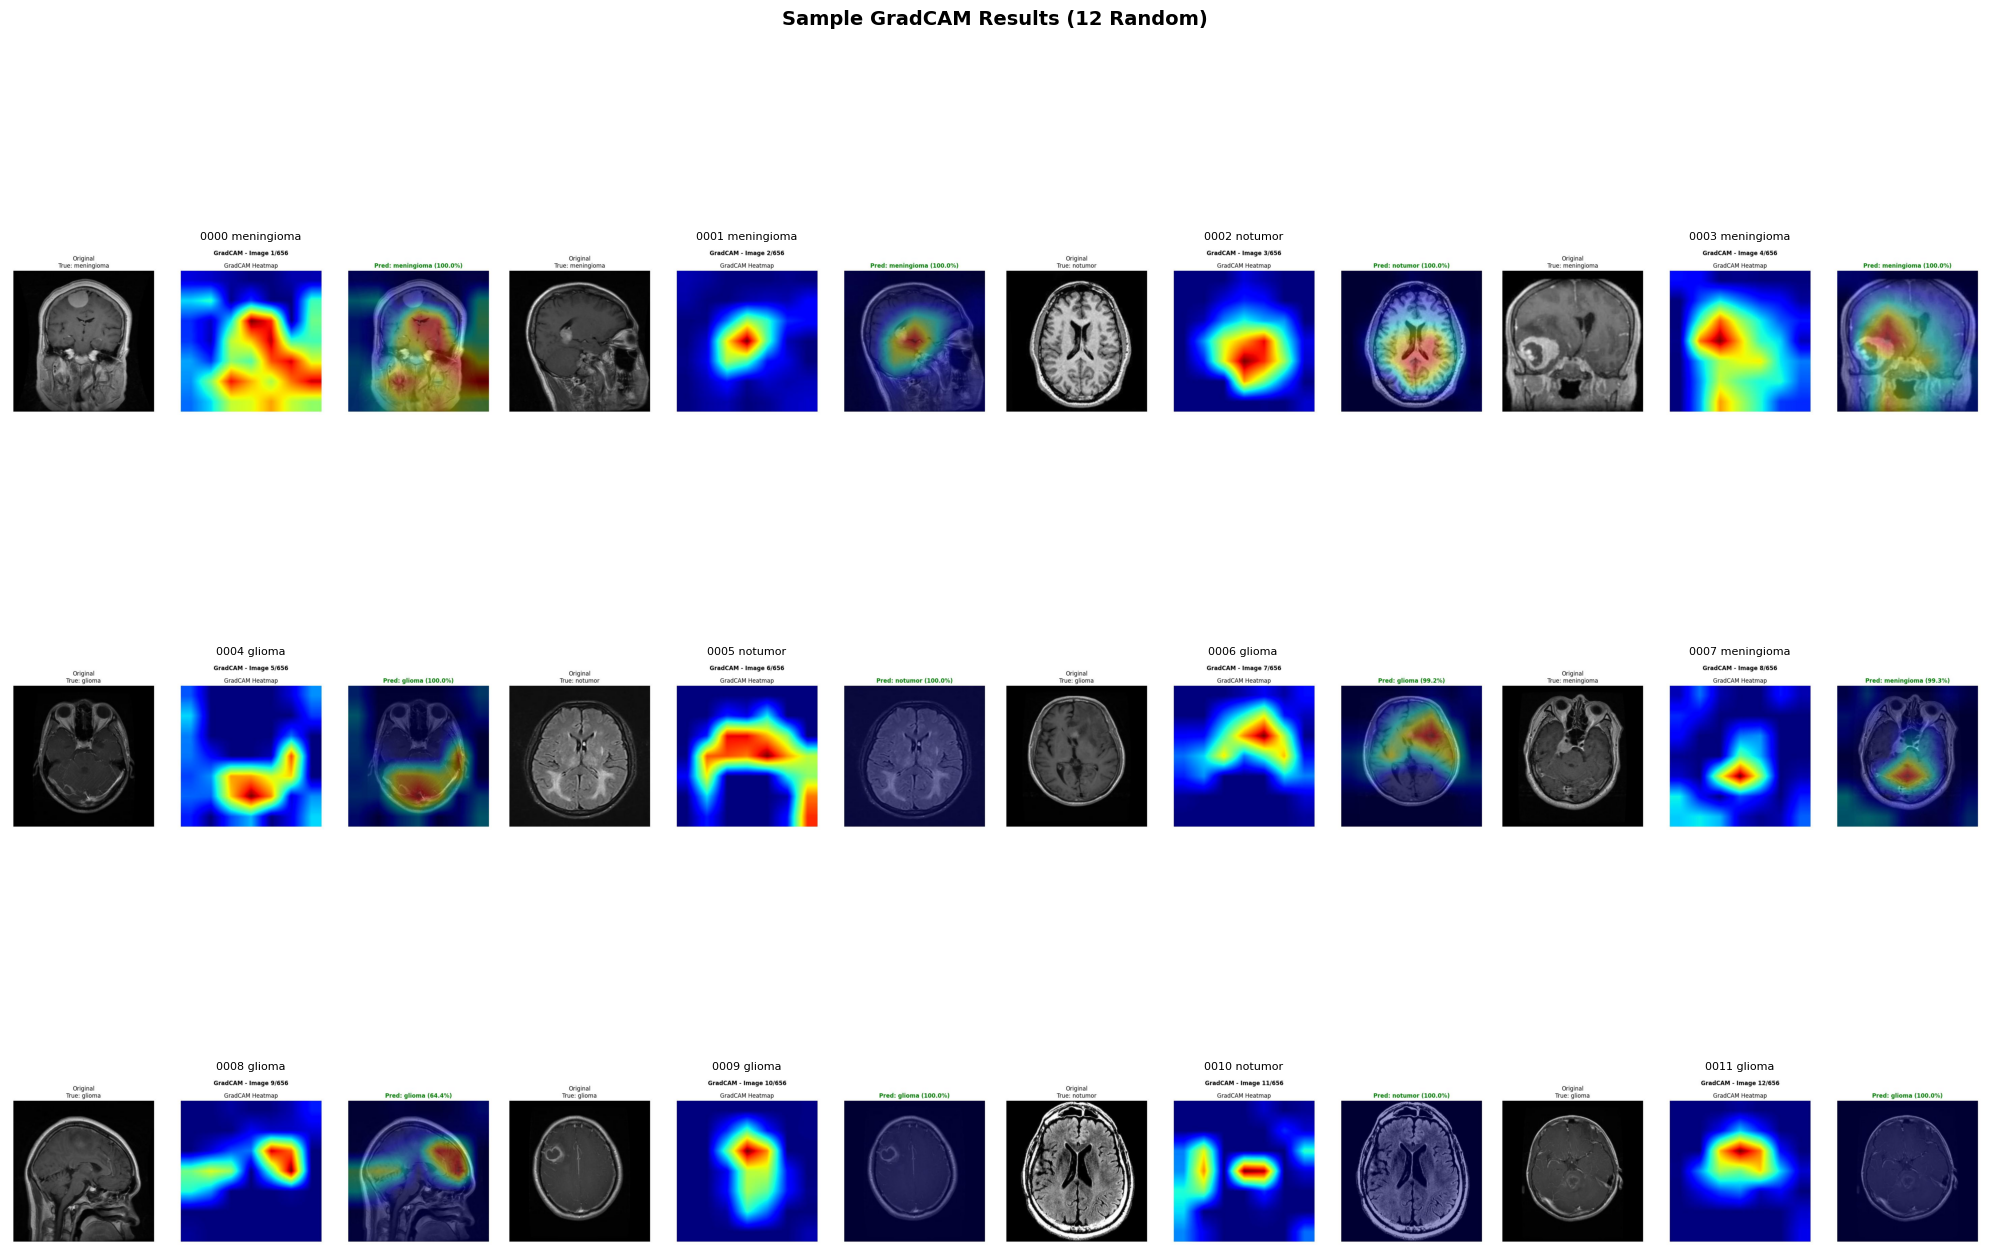

In [16]:
print("\nShowing 12 sample GradCAM results:")

sample_files = sorted(os.listdir(gradcam_dir))[:12]
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, filename in enumerate(sample_files):
    if idx >= 12:
        break
    img = plt.imread(os.path.join(gradcam_dir, filename))
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(filename.split('_pred_')[0].replace('_', ' '), fontsize=8)

plt.suptitle('Sample GradCAM Results (12 Random)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Display Wrong Predictions with GradCAM

ANALYZING WRONG PREDICTIONS
Total wrong predictions: 2 / 656
Accuracy: 99.70%

Displaying wrong predictions with GradCAM...


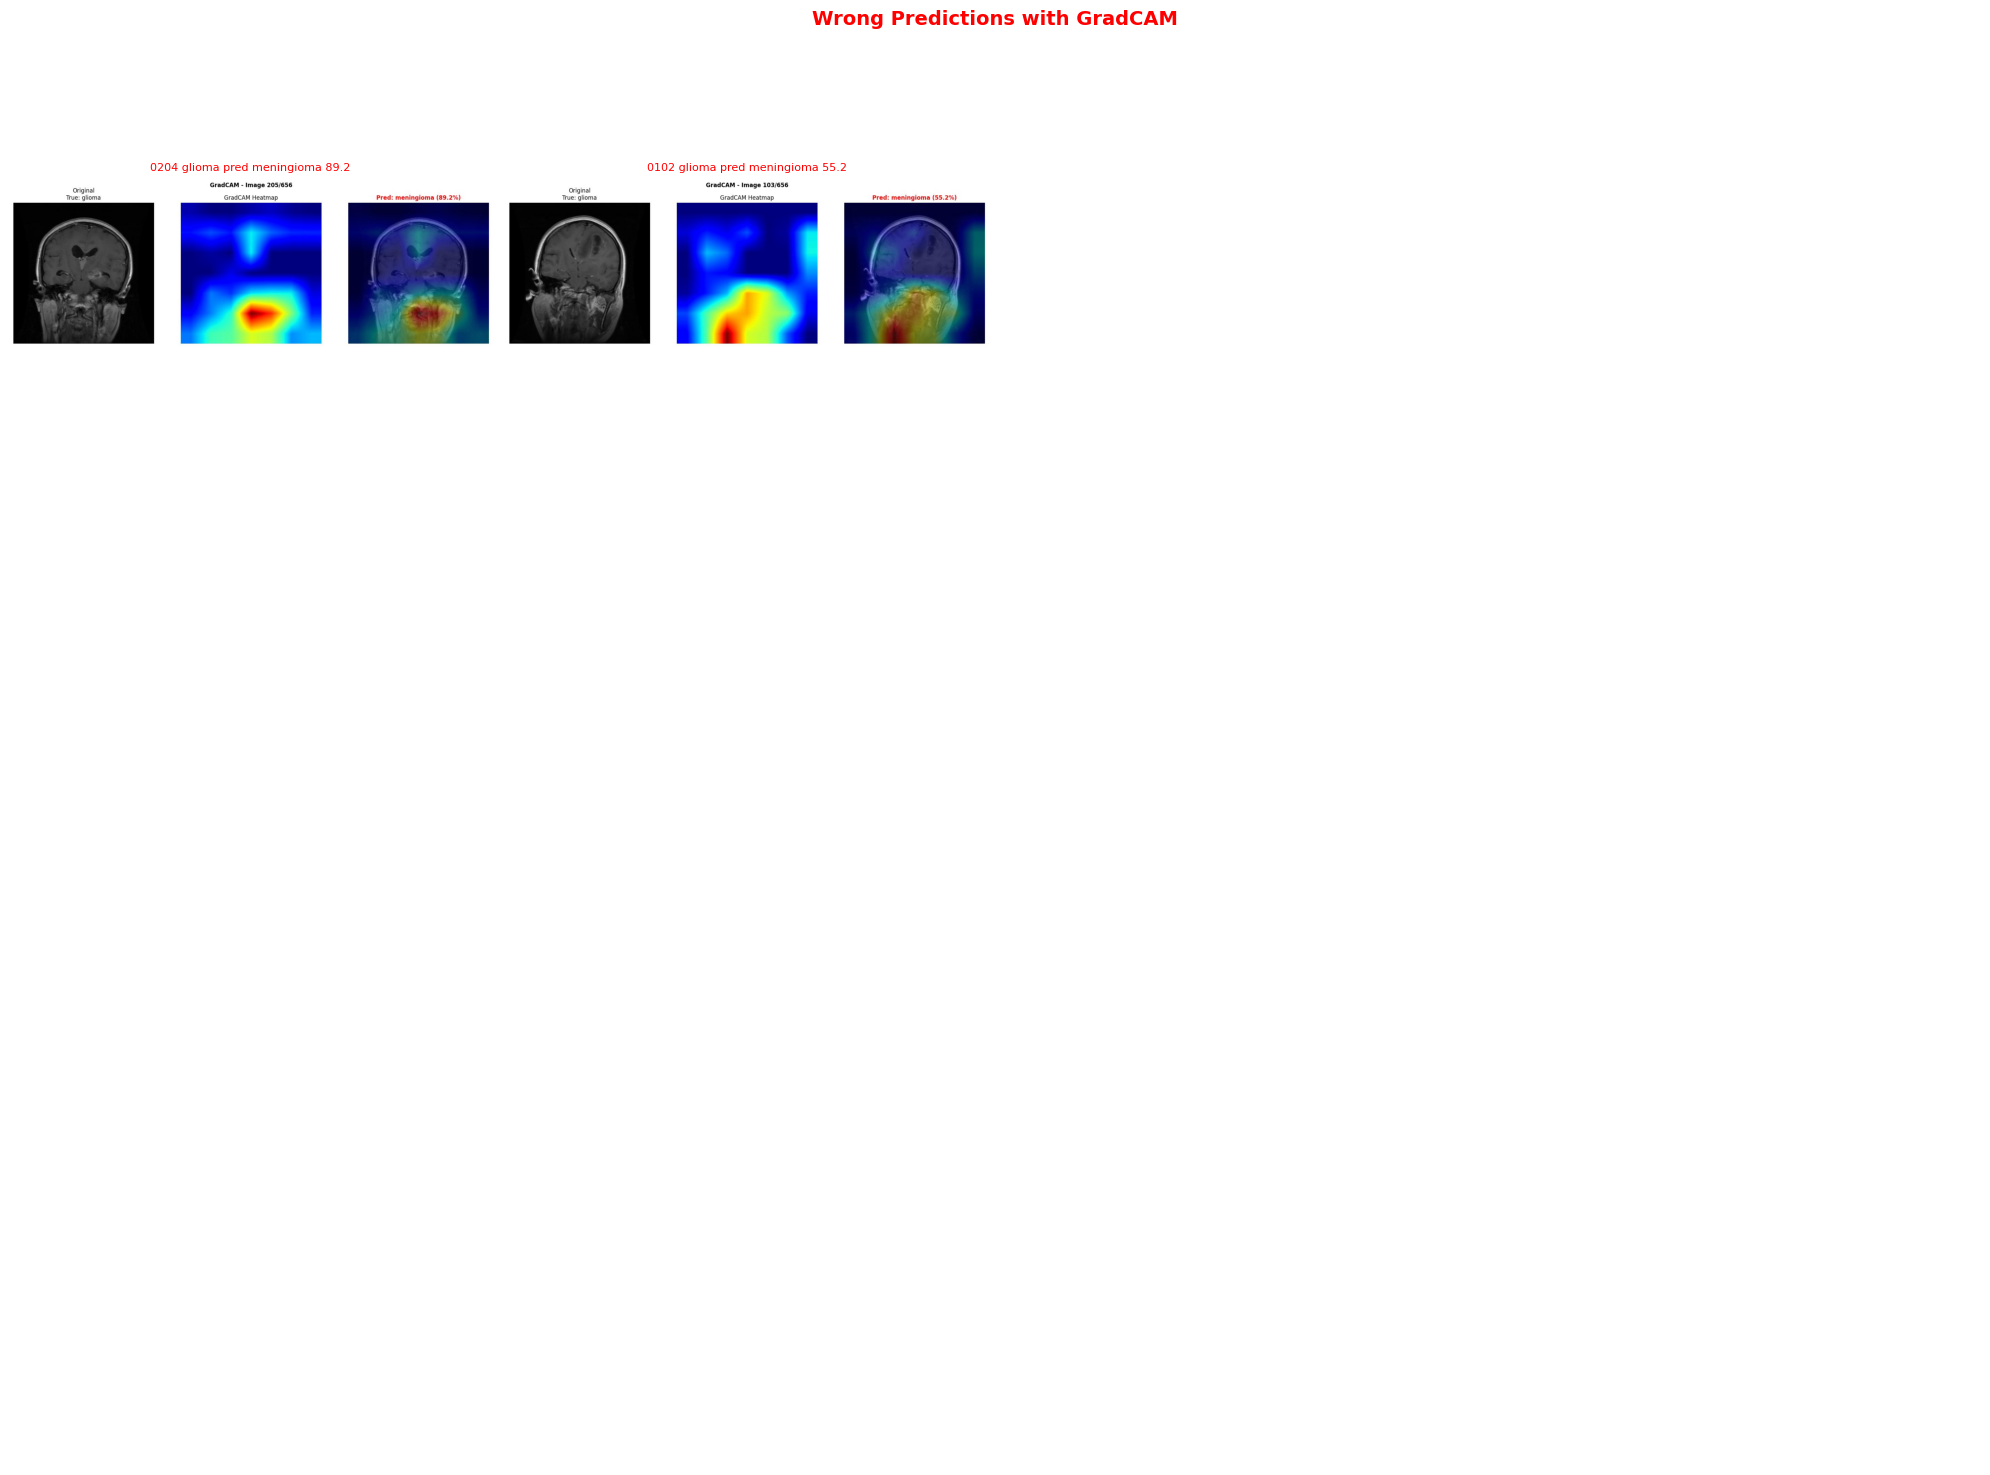

In [17]:
print("ANALYZING WRONG PREDICTIONS")

# Get all predictions
all_preds = []
all_labels = []

for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    batch_preds = model.predict(X_batch, verbose=0)
    all_preds.extend(batch_preds)
    all_labels.extend(np.argmax(y_batch, axis=1))

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
y_pred = np.argmax(all_preds, axis=1)

wrong_indices = np.where(y_pred != all_labels)[0]
print(f"Total wrong predictions: {len(wrong_indices)} / {len(all_labels)}")
print(f"Accuracy: {(1 - len(wrong_indices)/len(all_labels))*100:.2f}%")

if len(wrong_indices) > 0:
    print("\nDisplaying wrong predictions with GradCAM...")
    wrong_files = [f for f in os.listdir(gradcam_dir) if any(str(idx).zfill(4) in f for idx in wrong_indices)][:12]
    
    if wrong_files:
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))
        axes = axes.flatten()
        
        for idx, filename in enumerate(wrong_files):
            if idx >= 12:
                break
            img = plt.imread(os.path.join(gradcam_dir, filename))
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(filename.replace('.jpg', '').replace('_', ' '), fontsize=8, color='red')
        
        for idx in range(len(wrong_files), 12):
            axes[idx].axis('off')
        
        plt.suptitle('Wrong Predictions with GradCAM', fontsize=14, fontweight='bold', color='red')
        plt.tight_layout()
        plt.show()
else:
    print("No wrong predictions.")


## 11. Save Final Model

In [18]:
model.save('brain_tumor_resnet50_final.keras')
print('\n✓ Model saved: brain_tumor_resnet50_final.keras')
print(f'Total params: {model.count_params():,}')
print(f'Trainable params: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}')


✓ Model saved: brain_tumor_resnet50_final.keras
Total params: 24,779,396
Trainable params: 5,652,228
